# PATIENT SIMILARITY

### Setup, Etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import h5py
import tables
import numpy as np
import seaborn as sns
from functools import reduce

In [3]:
# device = torch.device('cpu')
device = torch.device('cuda:0')

In [4]:
import os
os.chdir('/home/aisinai/work/repos/nis_patient_encoding/')

In [6]:
from data.data_loader import NISDatabase
from data.cohort_builder import CohortBuilder

from utils.experiments import *
from utils.feature_utils import calc_output_dims
from utils.code_mappings import *

from model.autoencoder.autoencoder import AutoEncoder
from model.autoencoder.loss import CustomLoss
from trainer.trainer import Trainer

### Construct Case Cohorts

In [7]:
DATA_FOLDER = 'data/raw/'

In [8]:
data = tables.open_file(DATA_FOLDER + 'NIS_Pruned.h5', 'r')

In [198]:
cb = CohortBuilder(DATA_FOLDER + 'NIS_Pruned.h5')

In [10]:
# inclusion_info = {'DXCCS': [122, 109]}
inclusion_info = {'DXCCS': [112, 109]}
case_control_info = {'DX': [map_icd9_to_numeric('42731'),]}
cohort_build_info = {'inclusion': inclusion_info, 'case_control': case_control_info}

In [11]:
cb.create_case_control(cohort_build_info)

DXCCS [122, 109]
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
DX [42731]
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000


In [169]:
np.save(DATA_FOLDER + 'NIS_caseindices.npy', cb.cases)
np.save(DATA_FOLDER + 'NIS_controlindices.npy', cb.controls)

In [271]:
# Sanity check
np.intersect1d(cb.cases, cb.controls)

array([], dtype=int64)

#### Autoencoder 4.0

In [ ]:
case_db = NISDatabase(DATA_FOLDER + 'NIS_2012_2014_proto_emb_v2.h5', 'TRAIN', {})
control_db = NISDatabase(DATA_FOLDER + 'NIS_2012_2014_proto_emb_v2.h5', 'TRAIN', {})

In [37]:
DATA_FOLDER = 'data/raw/'
INPUT_FEATURES = {
    'AGE' : {'type': 'one_hot', 'rep_func': None},
    'FEMALE' : {'type': 'one-hot', 'rep_func': None},
    'HCUP_ED' : {'type': 'one-hot', 'rep_func': None},
    'TRAN_IN' : {'type': 'one-hot', 'rep_func': None},
    'ELECTIVE' : {'type': 'one-hot', 'rep_func': None},
    'ZIPINC_QRTL' : {'type': 'one-hot', 'rep_func': None},
    'DXn' : {'type': 'embedding', 'rep_func': None},
    'ECODEn' : {'type': 'embedding', 'rep_func': None},
    'PRn' : {'type': 'embedding', 'rep_func': None},
    'CHRONn' : {'type': 'embedding', 'rep_func': None},
}

DEFAULT_BUILD = {
    'encoding' : {
        'total_layers' : 1,
        'scale' : 4,
        'activation' : 'leaky_relu',
    },

    'latent' : {'dimensions' : 64},

    'decoding' : {
        'scale' : 4,
        'activation' : 'leaky_relu',
        'total_layers' : 1,
        'output_dims' : None
    }
}

EMBEDDING_DICTIONARY = {

     'CHRONn' : {
        'header_prefix' : b'CHRON',
        'num_classes' : 12583,
        'dimensions' : 256,
    },   

    'DXn' : {
        'header_prefix' : b'DX',
        'num_classes' : 12583,
        'dimensions' : 256,
    },

    'PRn' : {
        'header_prefix' : b'PR',
        'num_classes' : 4445,
        'dimensions' : 64,
    },

    'ECODEn' : {
        'header_prefix' : b'ECODE',
        'num_classes' : 1186,
        'dimensions' : 32,
    },

    'CHRONBn' : {
        'header_prefix' : b'CHRONB',
        'num_classes' : 19,
        'dimensions' : 16,
    }
}

ONE_HOT_LIST = [b'ELECTIVE', b'FEMALE', b'HCUP_ED', b'TRAN_IN', b'ZIPINC_QRTL', b'AGE']
ONE_HOTS = { feature.decode('utf-8') : {} for feature in ONE_HOT_LIST }
ONE_HOTS['ELECTIVE']['num_classes'] = 2 # 0,1
ONE_HOTS['FEMALE']['num_classes'] = 2 # 0,1
ONE_HOTS['TRAN_IN']['num_classes'] = 3 # 0-2
ONE_HOTS['HCUP_ED']['num_classes'] = 5 # 0-4
ONE_HOTS['ZIPINC_QRTL']['num_classes'] = 5 # 1-4
ONE_HOTS['AGE']['num_classes'] = 13 # 0-12 (must be allowed to guess in between as well)

CONTINUOUS = {}

FEATURE_REPRESENTATIONS = {}
FEATURE_REPRESENTATIONS['embedding'] = EMBEDDING_DICTIONARY
FEATURE_REPRESENTATIONS['one_hots'] = ONE_HOTS
FEATURE_REPRESENTATIONS['continuous'] = CONTINUOUS

DEFAULT_BUILD['features'] = FEATURE_REPRESENTATIONS

find_nlike_features(case_db.headers, FEATURE_REPRESENTATIONS['embedding'])
FEATURE_REPRESENTATIONS['one_hots'] = create_onehot_info(case_db, FEATURE_REPRESENTATIONS['one_hots'], FEATURE_REPRESENTATIONS['embedding'])
DEFAULT_BUILD['features'] = FEATURE_REPRESENTATIONS
calc_output_dims(DEFAULT_BUILD)

In [13]:
ae = AutoEncoder(DEFAULT_BUILD).to(device)
ae.load_state('/home/aisinai/work/repos/nis_patient_encoding/experiments/train_ae_020/1587303827.pth', device=device)

In [154]:
case_db.set_inds(cb.cases)
control_db.set_inds(cb.controls)

In [155]:
case_dl = torch.utils.data.DataLoader(case_db, batch_size=1000, pin_memory=True, num_workers=4)
control_dl = torch.utils.data.DataLoader(control_db, batch_size=1000, pin_memory=True, num_workers=4)

In [156]:
all_cases = np.array([case for case in case_dl])

ValueError: only one element tensors can be converted to Python scalars

##### Batch into the latent space

In [116]:
try: cc_stroke.close()
except: pass

cc_stroke = tables.open_file(DATA_FOLDER + 'NIS_stroke_casecontrol_mod.h5', 'w')

In [174]:
ae.build_params

{'encoding': {'total_layers': 1, 'scale': 4, 'activation': 'leaky_relu'},
 'latent': {'dimensions': 64},
 'decoding': {'scale': 4,
  'activation': 'leaky_relu',
  'total_layers': 1,
  'output_dims': 826999.0},
 'features': {'embedding': {'CHRONn': {'header_prefix': b'CHRON',
    'num_classes': 12583,
    'dimensions': 256,
    'feature_idx': [1,
     2,
     3,
     4,
     5,
     6,
     7,
     8,
     9,
     10,
     11,
     12,
     13,
     14,
     15,
     16,
     17,
     18,
     19,
     20,
     21,
     22,
     23,
     24,
     25,
     26,
     27,
     28,
     29,
     30]},
   'DXn': {'header_prefix': b'DX',
    'num_classes': 12583,
    'dimensions': 256,
    'feature_idx': [61,
     62,
     63,
     64,
     65,
     66,
     67,
     68,
     69,
     70,
     71,
     72,
     73,
     74,
     75,
     76,
     77,
     78,
     79,
     80,
     81,
     82,
     83,
     84,
     85,
     86,
     87,
     88,
     89,
     90]},
   'PRn': {'header_prefix'

In [117]:
cc_stroke.create_earray('/', 'cases', shape=(0, DEFAULT_BUILD['latent']['dimensions']), atom=tables.FloatAtom());
cc_stroke.create_earray('/', 'controls', shape=(0, DEFAULT_BUILD['latent']['dimensions']), atom=tables.FloatAtom());

In [118]:
for idx, case_batch in enumerate(case_dl):
    print(idx * 1000, cc_stroke.root.cases.shape[0])
    case_batch = case_batch.to(device)
    cc_stroke.root.cases.append(np.array(ae.latent_representation(case_batch.to(device)).detach().to('cpu')))

0 0
1000 1000
2000 2000
3000 3000
4000 4000
5000 5000
6000 6000
7000 7000
8000 8000
9000 9000
10000 10000
11000 11000
12000 12000


In [119]:
for idx, control_batch in enumerate(control_dl):
    print(idx * 1000, cc_stroke.root.controls.shape[0], control_batch.shape[0])
    control_batch = control_batch.to(device)
    cc_stroke.root.controls.append(np.array(ae.latent_representation(control_batch.to(device)).detach().to('cpu')))

0 0 1000
1000 1000 1000
2000 2000 1000
3000 3000 1000
4000 4000 1000
5000 5000 1000
6000 6000 1000
7000 7000 1000
8000 8000 1000
9000 9000 1000
10000 10000 1000
11000 11000 1000
12000 12000 1000
13000 13000 1000
14000 14000 1000
15000 15000 1000
16000 16000 1000
17000 17000 1000
18000 18000 1000
19000 19000 1000
20000 20000 1000
21000 21000 1000
22000 22000 1000
23000 23000 1000
24000 24000 1000
25000 25000 1000
26000 26000 1000
27000 27000 1000
28000 28000 1000
29000 29000 1000
30000 30000 1000
31000 31000 1000
32000 32000 1000
33000 33000 1000
34000 34000 1000
35000 35000 1000
36000 36000 1000
37000 37000 1000
38000 38000 1000
39000 39000 1000
40000 40000 1000
41000 41000 1000
42000 42000 1000
43000 43000 1000
44000 44000 1000
45000 45000 1000
46000 46000 1000
47000 47000 1000
48000 48000 1000
49000 49000 1000
50000 50000 1000
51000 51000 1000
52000 52000 1000
53000 53000 1000
54000 54000 1000
55000 55000 1000
56000 56000 1000
57000 57000 1000
58000 58000 1000
59000 59000 1000
60000 

In [121]:
cc_stroke.root.controls.shape

(1782567, 64)

In [167]:
cc_stroke.close()

In [168]:
cc_stroke = tables.open_file(DATA_FOLDER + 'NIS_stroke_casecontrol_orig.h5', 'w')

cc_stroke.create_earray('/', 'cases_orig', shape=(0, 115), atom=tables.FloatAtom());
cc_stroke.create_earray('/', 'controls_orig', shape=(0, 115), atom=tables.FloatAtom());

for idx, case_batch in enumerate(case_dl):
    cc_stroke.root.cases_orig.append(np.array(case_batch.to('cpu')))

for idx, control_batch in enumerate(control_dl):
    cc_stroke.root.controls_orig.append(np.array(control_batch.to('cpu')))
    
cc_stroke.close()

## Building Trees

In [123]:
cc_stroke = tables.open_file(DATA_FOLDER + 'NIS_stroke_casecontrol_mod.h5', 'r')

#### Annoy

In [124]:
from annoy import AnnoyIndex
import cProfile

In [126]:
case_dl = torch.utils.data.DataLoader(case_db, batch_size=1000, pin_memory=True, num_workers=4)
control_dl = torch.utils.data.DataLoader(control_db, batch_size=1000, pin_memory=True, num_workers=4)

In [127]:
control_ann_tree = AnnoyIndex(ae.build_params['latent']['dimensions'], 'euclidean')

for idx, sample in enumerate(cc_stroke.root.controls):
    control_ann_tree.add_item(idx, sample)

control_ann_tree.build(100)
control_ann_tree.save(DATA_FOLDER + 'NIS_stroke_annoyindex_controls_100trees.ann');

True

In [128]:
case_ann_tree = AnnoyIndex(ae.build_params['latent']['dimensions'], 'euclidean')

for idx, sample in enumerate(cc_stroke.root.cases):
    case_ann_tree.add_item(idx, sample)

case_ann_tree.build(100)
case_ann_tree.save(DATA_FOLDER + 'NIS_stroke_annoyindex_cases_100trees.ann');    

True

#### Now, find nearest neighbors

In [129]:
cc_stroke = tables.open_file(DATA_FOLDER + 'NIS_stroke_casecontrol_mod.h5', 'r')

In [130]:
control_ann_tree = AnnoyIndex(ae.build_params['latent']['dimensions'], 'euclidean')
control_ann_tree.load(DATA_FOLDER + 'NIS_stroke_annoyindex_controls_100trees.ann');

In [131]:
case_ann_tree = AnnoyIndex(ae.build_params['latent']['dimensions'], 'euclidean')
case_ann_tree.load(DATA_FOLDER + 'NIS_stroke_annoyindex_cases_100trees.ann');

### Gale-Shapley

In [50]:
case_pref

array([  309.,  1299.,  2289.,  3279.,  4269.,  5259.,  6249.,  7239.,
        8229.,  9219., 10209., 11199., 12189., 13179., 14169., 15159.,
       16149., 17139., 18129., 19119., 20109., 21099., 22089., 23079.,
       24069., 25059., 26049., 27039., 28029., 29019., 30009., 30999.])

In [60]:
np.linalg.norm(cc_stroke.root.cases[current_control_match] - cc_stroke.root.controls[case_pref])

1.8806959814634383

In [70]:
np.sum(case_matches != -127)

1624

In [ ]:
a.

In [71]:
a = ['3', '10', 8]

In [79]:
len(remaining_matches)

11365

In [76]:
case_matches = -128 * np.ones((cc_stroke.root.cases.shape[0]))
control_matches = -128 * np.ones((cc_stroke.root.controls.shape[0]))

remaining_matches = [case for case in range(0, cc_stroke.root.cases.shape[0])]

kg = True
count = 0

while kg:
    case_to_match = remaining_matches.pop()
    case_pref = int(case_preferences[case_to_match, 0, :][0])
    
    if control_matches[case_pref] == -128: # if preference is free
        case_matches[case_to_match] = int(case_pref) # then marry
        
        control_matches[case_pref] = int(case_to_match)
        print("Match made in heaven! {0} with {1}".format(case_pref, case_to_match))
        
    else:
        current_control_match = int(control_matches[case_pref])
        control_prefs = control_preferences[case_pref, 0, :]
        
        if np.linalg.norm(cc_stroke.root.cases[current_control_match] - cc_stroke.root.controls[case_pref]) > \
            np.linalg.norm(cc_stroke.root.cases[case_to_match] - cc_stroke.root.controls[case_pref]):
            remaining_matches.insert(0, current_control_match)
            control_matches[case_pref] = case_to_match
            case_matches[case_to_match] = case_pref
            print("Wow! {0} is a homewrecker and just broke up {1} and {2}...".format(case_to_match, 
                                                                                      current_control_match, 
                                                                                      case_pref))
        else:
            print("Aw, poo. {0} is lonely...".format(case_to_match))
            remaining_matches.insert(0, case_to_match)
            pass
        
    count += 1
    
    # Stop criterion
    if np.sum(case_matches == -128) == 0 or count > 1000000: # or something else:
        kg = False

Match made in heaven! 989 with 12989
Match made in heaven! 988 with 12988
Match made in heaven! 987 with 12987
Match made in heaven! 986 with 12986
Match made in heaven! 985 with 12985
Match made in heaven! 984 with 12984
Match made in heaven! 983 with 12983
Match made in heaven! 982 with 12982
Match made in heaven! 981 with 12981
Match made in heaven! 980 with 12980
Match made in heaven! 979 with 12979
Match made in heaven! 978 with 12978
Match made in heaven! 977 with 12977
Match made in heaven! 976 with 12976
Match made in heaven! 975 with 12975
Match made in heaven! 974 with 12974
Match made in heaven! 973 with 12973
Match made in heaven! 972 with 12972
Match made in heaven! 971 with 12971
Match made in heaven! 970 with 12970
Match made in heaven! 969 with 12969
Match made in heaven! 968 with 12968
Match made in heaven! 967 with 12967
Match made in heaven! 966 with 12966
Match made in heaven! 965 with 12965
Match made in heaven! 964 with 12964
Match made in heaven! 963 with 12963
M

KeyboardInterrupt: 

### Vanilla Nearest Neighbors

In [139]:
p = cProfile.Profile()
p.enable()

nearest_neighbors = []
n_neighbors = 32

for idx, sample in enumerate(cc_stroke.root.cases):
    nearest_neighbors.append(
        control_ann_tree.get_nns_by_vector(sample, 
                                      n_neighbors, 
                                      search_k=-1, 
                                      include_distances=True)
    )

nearest_neighbors = np.array(nearest_neighbors)
nearest_neighbors[:, 0, :] = nearest_neighbors[:, 0, :].astype('int')
    
p.disable()

In [136]:
p = cProfile.Profile()
p.enable()

control_preferences = []
n_neighbors = 32

for idx, sample in enumerate(cc_stroke.root.controls):
    control_preferences.append(
        case_ann_tree.get_nns_by_vector(sample, 
                                      n_neighbors, 
                                      search_k=-1, 
                                      include_distances=True)
    )

control_preferences = np.array(control_preferences)
control_preferences[:, 0, :] = control_preferences[:, 0, :].astype('int')
    
p.disable()

In [140]:
unique, idx, inv, cnts = np.unique(nearest_neighbors[:, 0, 0], 
                                   return_index=True, 
                                   return_inverse=True, 
                                   return_counts=True)

In [141]:
where_unique_matches = idx[cnts==1] # these are the inds in nearest_neighbors with ideal matches
competing_neighbors = unique[cnts > 1]

cases_to_be_matched = np.arange(0, nearest_neighbors.shape[0])
where_matches_not_found = np.setdiff1d(cases_to_be_matched, where_unique_matches) # these are the inds in nearest_neighbors that still need to be matched

In [142]:
# Algorithm for now:

# matched = [cases x 1]
# already_matched = []
matched = -128 * np.ones((cc_stroke.root.cases.shape[0], 2))
already_matched_controls = []
already_matched_cases = []

# For each level:
for level in range(0, n_neighbors):
    print("Starting Level {0}".format(level))
    init_matched = len(already_matched_cases)
    
    unique, idx, inv, cnts = np.unique(nearest_neighbors[:, 0, level], 
                                       return_index=True, 
                                       return_inverse=True, 
                                       return_counts=True)
    
    unique_matches_case = idx[cnts == 1]
    unique_matches_control = unique[cnts == 1] 

    # Identify unique matches and assign those
        # Update 'matched'
        # Update 'already_matched'
        
    for unique_case, unique_control in zip(unique_matches_case, unique_matches_control):
        
        # Remove matches that have already been assigned (already_matched)
        if unique_control in already_matched_controls:
            continue
            
        if unique_case in already_matched_cases:
            continue
        
        matched[unique_case, 0] = unique_control
        already_matched_controls.append(unique_control)
        already_matched_cases.append(unique_case)
        
#         print("Matched Case {0} with Control {1}".format(unique_case, unique_control))
           
    # Identify competing matches
        # For each competing match:
            # Assign match to that with the lowest distance
            # Update 'matched'
            # Update 'already_matched'
    
    competing_controls = unique[cnts > 1]
        
    for competing_control in competing_controls:
        if competing_control in already_matched_controls:
            continue
        
        competing_cases = np.where(nearest_neighbors[:, 0, level] == competing_control)
        competing_cases = np.setdiff1d(competing_cases, already_matched_cases)
        
        if len(competing_cases) > 0:
            competing_dists = nearest_neighbors[competing_cases, 1, level]
            winner = competing_cases[np.argmin(competing_dists)]
            matched[winner, 0] = competing_control
        
            already_matched_controls.append(competing_control)
            already_matched_cases.append(winner)
            
#             print("Matched Case {0} with Control {1}".format(winner, competing_control))
            
    print("Level {2} finished. Matched {0}. Remaining {1}.".format(len(already_matched_cases) - init_matched, nearest_neighbors.shape[0] - len(already_matched_cases), level))
    if len(already_matched_cases) == nearest_neighbors.shape[0]:
        break

Starting Level 0
Level 0 finished. Matched 12482. Remaining 508.
Starting Level 1
Level 1 finished. Matched 458. Remaining 50.
Starting Level 2
Level 2 finished. Matched 46. Remaining 4.
Starting Level 3
Level 3 finished. Matched 2. Remaining 2.
Starting Level 4
Level 4 finished. Matched 2. Remaining 0.


In [143]:
matched = matched[:, 0].astype('int')

In [144]:
len(already_matched_cases), np.unique(matched).shape[0] - 1

(12990, 12989)

In [145]:
cases_matched = np.where(matched >= 0)[0]
controls_matched = matched[matched >= 0]

In [153]:
cases_matched

array([    0,     1,     2, ..., 12987, 12988, 12989])

#### Perform Stats

In [146]:
case_inds = cb.cases[cases_matched]
control_inds = cb.controls[controls_matched]

case_db.set_inds(case_inds)
control_db.set_inds(control_inds)

case_dl = torch.utils.data.DataLoader(case_db, batch_size=1000, pin_memory=True, num_workers=4)
control_dl = torch.utils.data.DataLoader(control_db, batch_size=1000, pin_memory=True, num_workers=4)

In [147]:
case_data = {}

for idx, case_batch in enumerate(case_dl):
    _, target = ae.embed(case_batch.to(device))
    
    for feature, recon in target.items():
        if feature not in list(case_data.keys()):
            recon_np = np.array(recon.detach().to('cpu'))
            case_data[feature] = recon_np
        else:
            recon_np = np.array(recon.detach().to('cpu'))
            case_data[feature] = np.vstack((case_data[feature], recon_np))

In [148]:
control_data = {}

for idx, control_batch in enumerate(control_dl):
    _, target = ae.embed(control_batch.to(device))
    
    for feature, recon in target.items():
        if feature not in list(control_data.keys()):
            recon_np = np.array(recon.detach().to('cpu'))
            control_data[feature] = recon_np
        else:
            recon_np = np.array(recon.detach().to('cpu'))
            control_data[feature] = np.vstack((control_data[feature], recon_np))

In [149]:
from scipy.stats import chisquare
import pandas as pd

t_test_vals = pd.DataFrame(index=case_data.keys(), columns=['p_value', ])

t_tests = {}
for (_, case), (feature_name, control) in zip(case_data.items(), control_data.items()): 
#     if feature_name[-1] != 'n':
    t_tests[feature_name] = {}

    tfn = t_tests[feature_name] # shorthand
    
    # Find number of class representatives
    ft_0 = np.sum(control, axis=0)
    ft_1 = np.sum(case, axis=0)
    
    # Remove nonzero classes
    ft_nonzero = np.array([[ft_0i, ft_1i] for ft_0i, ft_1i in zip(ft_0, ft_1) if ft_1i != 0]).astype('int')

#     print(feature_name, (ft_nonzero[:, 0], ft_nonzero[:, 1]))
    t_tests[feature_name]['case_control'] = pd.DataFrame(np.vstack((ft_0, ft_1)).T, columns=['CONTROL', 'CASE']).rename_axis(feature_name)
    
    # Compute the chi-sq value and p-value
    tfn['chisq'], tfn['pval'] = chisquare(ft_nonzero[:, 0], ft_nonzero[:, 1])
    t_tests[feature_name]['p_value'] = tfn['pval']
    t_tests[feature_name]['chisq'] = tfn['chisq']
    t_test_vals.loc[feature_name, 'p_value'] =  tfn['pval']
    t_test_vals.loc[feature_name, 'chisq'] =  tfn['chisq']
    t_test_vals.loc[feature_name, 'type'] =  'cat'
    
# all_ttests.append(t_tests)

In [180]:
t_test_vals

,p_value,chisq,type
CHRONn,0,12435.001477,cat
DXn,0,20431.496822,cat
PRn,0,5818.321379,cat
ECODEn,6.82403e-87,832.666582,cat
CHRONBn,3.6888e-283,1375.086418,cat
ELECTIVE,0.62805,0.234714,cat
FEMALE,0.957925,0.002783,cat
HCUP_ED,0.0725853,8.577067,cat
TRAN_IN,0.691463,0.737890,cat
ZIPINC_QRTL,0.995038,0.071351,cat


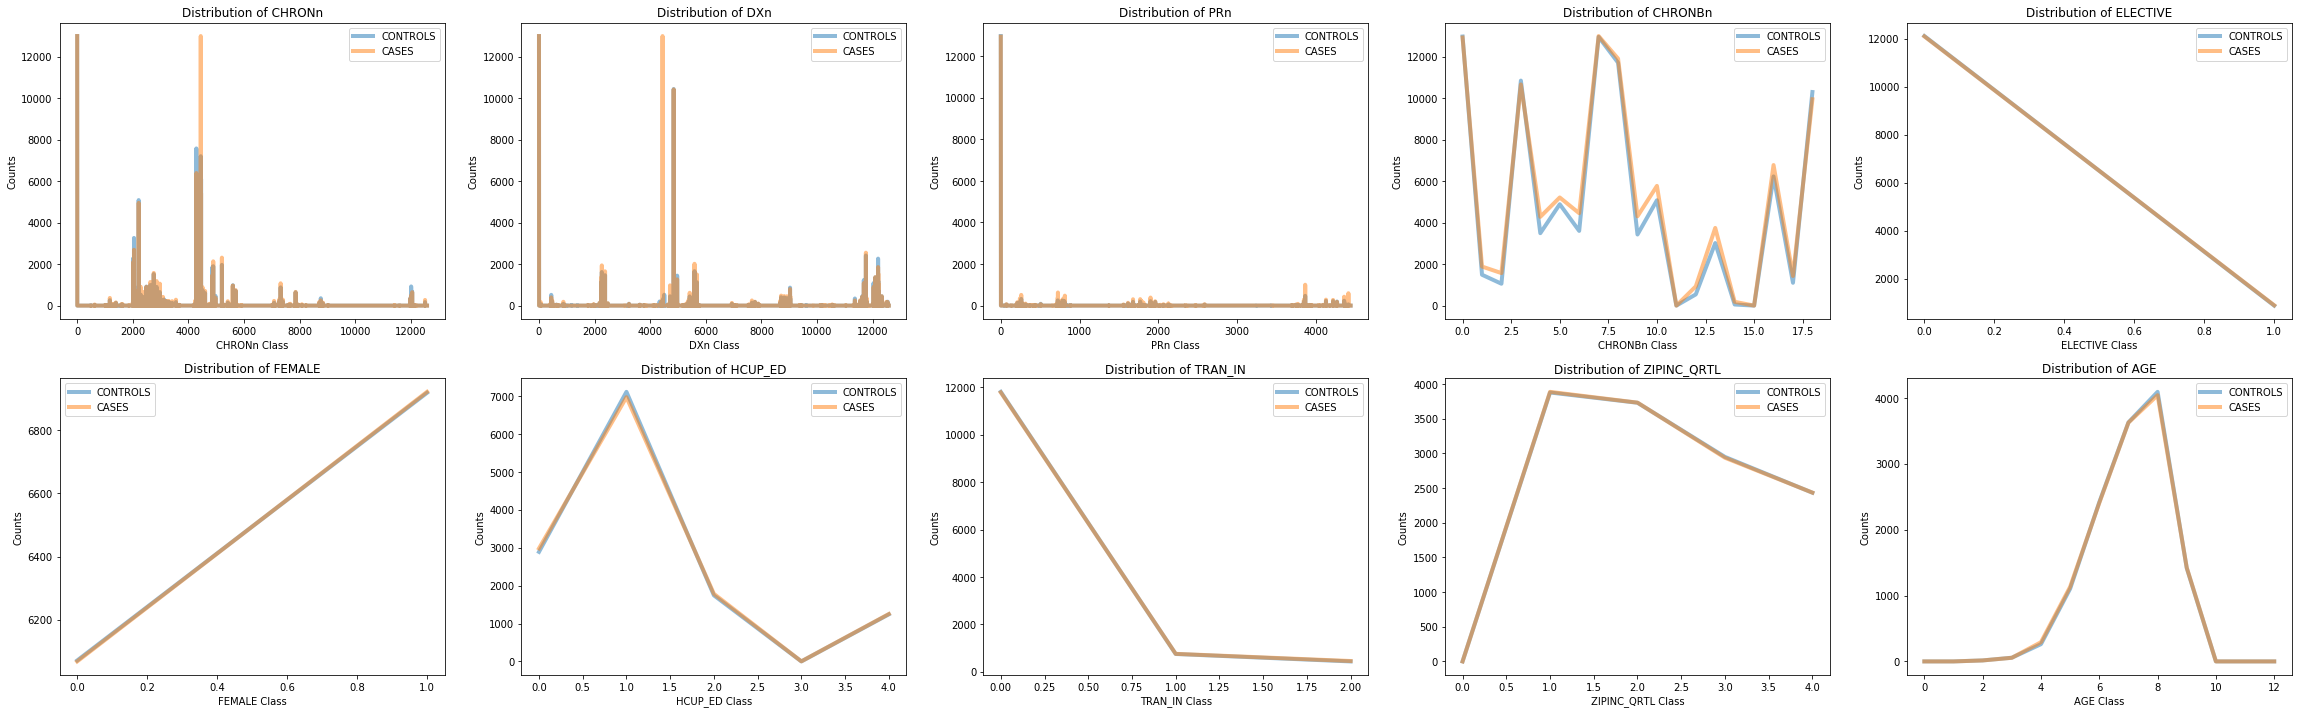

In [183]:
# t_tests = all_ttests[0]
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 12))

count = 1
for feature_name in t_tests.keys():
    if feature_name != 'ECODEn':
        plt.subplot(2, 5, count)
        plt.plot(t_tests[feature_name]['case_control'], alpha=0.5, linewidth=4)
        plt.legend(['CONTROLS', 'CASES'])
        plt.xlabel("{0} Class".format(feature_name))
        plt.ylabel("Counts".format(feature_name))
        plt.title("Distribution of {0}".format(feature_name))
        count += 1

In [185]:
print("CASE: ", np.sum(case_data['FEMALE'], axis=0))
print("CONTROL: ", np.sum(control_data['FEMALE'], axis=0))

CASE:  [6068. 6922.]
CONTROL:  [6071. 6919.]


### Now, on outcomes

In [91]:
import tables

In [186]:
# full_data = tables.open_file(DATA_FOLDER + 'NIS_Pruned.h5', 'r')
# ind_mapping = tables.open_file(DATA_FOLDER + 'NIS_2012_2014_proto_emb_red.h5', 'r').root.TRAIN

outcomes = data.root.outcomes
outcome_headers = data.root.outcome_headers[:]

In [187]:
case_outcomes = data.root.outcomes[case_inds, :]
control_outcomes = data.root.outcomes[control_inds, :]

In [188]:
outcome_headers

array([b'APRDRG', b'APRDRG_Risk_Mortality', b'APRDRG_Severity', b'DIED',
       b'DISPUNIFORM', b'DRG', b'LOS', b'TOTCHG'], dtype='|S21')

In [189]:
case_outcomes.shape, control_outcomes.shape

((12990, 8), (12990, 8))

In [190]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[remove_missing(a).reshape(-1)])

In [191]:
def remove_missing(a):
    a[a == -128.0] = 0
    return a

In [192]:
from scipy.stats import ttest_ind

In [193]:
test_map = {'cont': ttest_ind, 'cat': chisquare}
outcome_headers_tests = ['cont', 'cat', 'cat', 'cat', 'cat', None, 'cont', 'cont']
process_func = {'cat': one_hot, 'cont': lambda x, y: remove_missing(x)}
outcome_headers_tests = {header : {'type': test, 'test': test_map[test], 'process': process_func[test]}  for header, test in zip(outcome_headers, outcome_headers_tests) if test is not None}

In [194]:
from scipy.stats import chisquare, ttest_ind
import pandas as pd

# t_test_vals = pd.DataFrame(index=targets.keys(), columns=['p_value', ])

# t_tests = {}


for outcome_idx, outcome in enumerate(outcome_headers): 
    if outcome in outcome_headers_tests.keys():
        
        case_outcome_i = case_outcomes[:, outcome_idx]
        ft_1 = outcome_headers_tests[outcome]['process'](case_outcome_i, case_outcome_i.max() + 1)
        
        control_outcome_i = control_outcomes[:, outcome_idx]
        ft_0 = outcome_headers_tests[outcome]['process'](control_outcome_i, control_outcome_i.max() + 1)

        t_tests[feature_name] = {}

        tfn = t_tests[feature_name] # shorthand

        # Find number of class representatives
        ft_0 = np.sum(control, axis=0)
        ft_1 = np.sum(case, axis=0)

        # Remove nonzero classes
        ft_nonzero = np.array([[ft_0i, ft_1i] for ft_0i, ft_1i in zip(ft_0, ft_1) if ft_1i != 0]).astype('int')

    #     print(feature_name, (ft_nonzero[:, 0], ft_nonzero[:, 1]))
        t_tests[feature_name]['case_control'] = pd.DataFrame(np.vstack((ft_0, ft_1)).T, columns=['CONTROL', 'CASE']).rename_axis(feature_name)

        # Compute the chi-sq value and p-value
        tfn['chisq'], tfn['pval'] = chisquare(ft_nonzero[:, 0], ft_nonzero[:, 1])
        t_tests[feature_name]['p_value'] = tfn['pval']
        t_tests[feature_name]['chisq'] = tfn['chisq']
        t_test_vals.loc[feature_name, 'p_value'] =  tfn['pval']
        t_test_vals.loc[feature_name, 'chisq'] =  tfn['chisq']
        t_test_vals.loc[feature_name, 'type'] =  'cat'


        
        
        t_tests[outcome] = {}
        tfn = t_tests[outcome] # shorthand
#         ft_0 = outcome_data[batch_kmeans.labels_ == 0]
#         ft_1 = outcome_data[batch_kmeans.labels_ == 1]
        
        if outcome_headers_tests[outcome]['type'] == 'cat':
            ft_0 = np.sum(ft_0, axis=0)
            ft_1 = np.sum(ft_1, axis=0)

        ft_nonzero = np.array([[ft_0i, ft_1i] for ft_0i, ft_1i in zip(ft_0, ft_1) if ft_1i != 0])
        
        if outcome_headers_tests[outcome]['type'] == 'cat':
            tfn['control'] = ft_nonzero[:, 0]
            tfn['case'] = ft_nonzero[:, 1]
        else:
            tfn['control'] = np.mean(ft_nonzero[:, 0])
            tfn['case'] = np.mean(ft_nonzero[:, 1])

        tfn['chisq'], tfn['pval'] = outcome_headers_tests[outcome]['test'](ft_nonzero[:, 0], ft_nonzero[:, 1])
        t_test_vals.loc[outcome.decode('utf-8'), 'type'] =  outcome_headers_tests[outcome]['type']
        t_test_vals.loc[outcome.decode('utf-8'), 'p_value'] =  tfn['pval']

In [195]:
outcome_headers

array([b'APRDRG', b'APRDRG_Risk_Mortality', b'APRDRG_Severity', b'DIED',
       b'DISPUNIFORM', b'DRG', b'LOS', b'TOTCHG'], dtype='|S21')

In [196]:
t_tests[b'DISPUNIFORM']

{'control': array([1.000e+00, 6.235e+03, 4.020e+02, 3.346e+03, 2.318e+03, 1.100e+02,
        5.700e+02, 8.000e+00]),
 'case': array([1.000e+00, 6.081e+03, 4.810e+02, 3.549e+03, 2.183e+03, 1.000e+02,
        5.890e+02, 6.000e+00]),
 'chisq': 39.11468099452614,
 'pval': 1.8584418173047278e-06}

In [197]:
t_test_vals

,p_value,chisq,type
CHRONn,0,12435.001477,cat
DXn,0,20431.496822,cat
PRn,0,5818.321379,cat
ECODEn,6.82403e-87,832.666582,cat
CHRONBn,3.6888e-283,1375.086418,cat
ELECTIVE,0.62805,0.234714,cat
FEMALE,0.957925,0.002783,cat
HCUP_ED,0.0725853,8.577067,cat
TRAN_IN,0.691463,0.737890,cat
ZIPINC_QRTL,0.995038,0.071351,cat


##### Similarity Metrics on Batch in Latent Space

In [17]:
# Assess patient similarity
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
batch_euclidean = euclidean_distances(batch_ls)
batch_cossim = cosine_similarity(batch_ls)

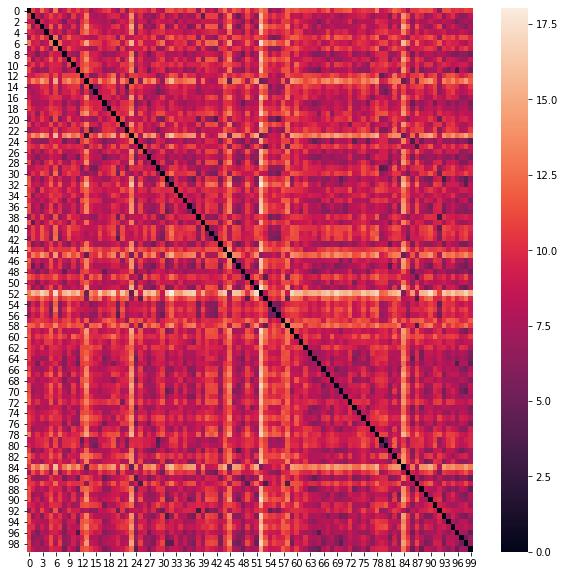

In [43]:
plt.figure(figsize=(10, 10))
sns.heatmap(batch_euclidean[:100, :100])

##### KMeans

In [36]:
from sklearn.cluster import KMeans

In [40]:
batch_kmeans = KMeans(n_clusters=2, random_state=0, precompute_distances=True, n_jobs=8).fit(batch_ls)

#### Perform Stats

In [45]:
targets

{'DXn': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 'PRn': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 'ECODEn': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 'CHRONBn': tensor([[1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 1., 0., 1.],
         ...,
         [1., 0., 1.,  ..., 0., 0., 1.],
 

In [76]:
targets.keys()

dict_keys(['DXn', 'PRn', 'ECODEn', 'CHRONBn', 'ELECTIVE', 'FEMALE', 'HCUP_ED', 'TRAN_IN', 'ZIPINC_QRTL', 'AGE'])

In [178]:
from scipy.stats import chisquare
import pandas as pd

t_test_vals = pd.DataFrame(index=targets.keys(), columns=['p_value', ])

t_tests = {}
for feature_name, feature in targets.items(): 
#     if feature_name[-1] != 'n':
    t_tests[feature_name] = {}
    tfn = t_tests[feature_name] # shorthand
    ft_0 = torch.sum(feature[batch_kmeans.labels_ == 0], axis=0).detach()
    ft_1 = torch.sum(feature[batch_kmeans.labels_ == 1], axis=0).detach()

    ft_nonzero = np.array([[ft_0i, ft_1i] for ft_0i, ft_1i in zip(ft_0, ft_1) if ft_1i != 0])
    tfn['ft_0'] = ft_nonzero[:, 0]
    tfn['ft_1'] = ft_nonzero[:, 1]

    tfn['chisq'], tfn['pval'] = chisquare(tfn['ft_0'], tfn['ft_1'])
    t_test_vals.loc[feature_name, 'p_value'] =  tfn['pval']
    t_test_vals.loc[feature_name, 'type'] =  'cat'

In [89]:
t_test_vals

,p_value
DXn,0
PRn,0
ECODEn,0
CHRONBn,0
ELECTIVE,0
FEMALE,0
HCUP_ED,0
TRAN_IN,0
ZIPINC_QRTL,0
AGE,0


Now, on outcomes

In [91]:
import tables

In [171]:
full_data = tables.open_file(DATA_FOLDER + 'NIS_Pruned.h5', 'r')
ind_mapping = tables.open_file(DATA_FOLDER + 'NIS_2012_2014_proto_emb_red.h5', 'r').root.TRAIN

outcomes = full_data.root.outcomes
outcome_headers = full_data.root.outcome_headers[:]

In [172]:
samp_batch_inds = ind_mapping[:10000]
batch_outcomes = outcomes[samp_batch_inds, :]

In [165]:
outcome_headers

array([b'APRDRG', b'APRDRG_Risk_Mortality', b'APRDRG_Severity', b'DIED',
       b'DISPUNIFORM', b'DRG', b'LOS', b'TOTCHG'], dtype='|S21')

In [173]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[remove_missing(a).reshape(-1)])

In [174]:
def remove_missing(a):
    a[a == -128.0] = 0
    return a

In [175]:
test_map = {'cont': ttest_ind, 'cat': chisquare}
outcome_headers_tests = ['cont', 'cat', 'cat', 'cat', 'cat', None, 'cont', 'cont']
process_func = {'cat': one_hot, 'cont': lambda x, y: remove_missing(x)}
outcome_headers_tests = {header : {'type': test, 'test': test_map[test], 'process': process_func[test]}  for header, test in zip(outcome_headers, outcome_headers_tests) if test is not None}

In [179]:
from scipy.stats import chisquare, ttest_ind
import pandas as pd

# t_test_vals = pd.DataFrame(index=targets.keys(), columns=['p_value', ])

# t_tests = {}
for outcome_idx, outcome in enumerate(outcome_headers): 
    if outcome in outcome_headers_tests.keys():
        
        outcome_data = batch_outcomes[:, outcome_idx]
        outcome_data = outcome_headers_tests[outcome]['process'](outcome_data, outcome_data.max() + 1)
        
        t_tests[outcome] = {}
        tfn = t_tests[outcome] # shorthand
        ft_0 = outcome_data[batch_kmeans.labels_ == 0]
        ft_1 = outcome_data[batch_kmeans.labels_ == 1]
        
        if outcome_headers_tests[outcome]['type'] == 'cat':
            ft_0 = np.sum(ft_0, axis=0)
            ft_1 = np.sum(ft_1, axis=0)

        ft_nonzero = np.array([[ft_0i, ft_1i] for ft_0i, ft_1i in zip(ft_0, ft_1) if ft_1i != 0])
        tfn['ft_0'] = ft_nonzero[:, 0]
        tfn['ft_1'] = ft_nonzero[:, 1]

        tfn['chisq'], tfn['pval'] = outcome_headers_tests[outcome]['test'](tfn['ft_0'], tfn['ft_1'])
        t_test_vals.loc[outcome.decode('utf-8'), 'type'] =  outcome_headers_tests[outcome]['type']
        t_test_vals.loc[outcome.decode('utf-8'), 'p_value'] =  tfn['pval']

In [180]:
t_test_vals

,p_value,type
DXn,0,cat
PRn,0,cat
ECODEn,0,cat
CHRONBn,0,cat
ELECTIVE,0,cat
FEMALE,0,cat
HCUP_ED,0,cat
TRAN_IN,0,cat
ZIPINC_QRTL,0,cat
AGE,0,cat


## Building Trees

#### Annoy

In [195]:
from annoy import AnnoyIndex

In [198]:
index_annoy = AnnoyIndex(ae.build_params['latent']['dimensions'], 'euclidean')

In [211]:
for batch_idx, sample in enumerate(db_dl):
    batch_ls = ae.latent_representation(batch).detach()
    
    for i, s in enumerate(batch_ls):
        s_id = i + batch_idx * 10000
        t.add_item(s_id, s)
    
        if (s_id % 1000) == 0:
            print(s_id)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


KeyboardInterrupt: 

In [212]:
t.build(100)

True

#### NMSLIB

In [26]:
import nmslib
import time

In [24]:
index_hnsw = nmslib.init(method='hnsw', space='cosinesimil')

In [30]:
for idx, batch in enumerate(db_dl):
    batch_ls = ae.latent_representation(batch).detach()
    index_hnsw.addDataPointBatch(np.array(batch_ls))
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


KeyboardInterrupt: 

In [31]:
# Create an index
start = time.time()
index_time_params = {'M': 15, 'indexThreadQty': 4, 'efConstruction': 100}
index_hnsw.createIndex(index_time_params) 
end = time.time() 
print('Index-time parameters', index_time_params)
print('Indexing time = %f' % (end-start))

Index-time parameters {'M': 15, 'indexThreadQty': 4, 'efConstruction': 100}
Indexing time = 11.473604
